<a href="https://colab.research.google.com/github/AdnaneMOUZAOUI/Analyse-de-sentiments-machine-learning/blob/Reviews-Analysis/RandomForest_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Travaille sur les commentaires seuls sans les titres.

In [ ]:
# Importer le fichier depuis le drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import re
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [ ]:
df = pd.read_csv('commentaires_prepares.csv', index_col=[0])
display(df.head())
df_save=df
df=df_save

,client,star,date_commande,date,nbr_avis,Commentaire,pays,Titre,longueur,majuscule,...,"ngrams_3_('délai', 'livraison', 'respecté').1","ngrams_3_('très', 'bon', 'produit').1","ngrams_3_('livraison', 'peu', 'longue').1","ngrams_3_('délai', 'livraison', 'trop').1","ngrams_3_('livraison', 'trop', 'longue').1","ngrams_3_('livraison', 'beaucoup', 'trop').1","ngrams_3_('entre', 'commande', 'livraison').1","ngrams_3_('bon', 'rapport', 'qualité').1","ngrams_3_('délais', 'livraison', 'trop').1","ngrams_3_('plus', 'dun', 'mois').1"
0,Agani,1.0,: 26 août 2022,2023-02-27,2.0,"['jamais', 'reçu', 'commande', 'écris', 'showr...",FR,Je n’ai jamais reçu ma commande,427,7,...,0,0,0,0,0,0,0,0,0,0
1,CHANTAL SLATKINE,1.0,: 26 février 2023,2023-02-27,2.0,"['commandé', 'collier', 'lun', 'ok', 'lautre',...",FR,J'ai commandé 2 colliers,537,13,...,0,0,0,0,0,0,0,0,0,0
2,LDC,1.0,: 26 février 2023,2023-02-27,2.0,"['commandé', 'airpods', 'reconditionnés', 'dit...",FR,Très déçue de la dernière commande.,563,8,...,0,0,0,0,0,0,0,0,0,0
3,anass jeffal,1.0,: 27 octobre 2022,2023-02-27,1.0,"['produit', 'acheté', 'septembre', 'retourné',...",FR,Produit acheté en Septembre 2022…,612,6,...,0,0,0,0,0,0,0,0,0,0
4,aurélien,1.0,: 27 février 2023,2023-02-27,1.0,"['encore', 'commande', 'partiellement', 'annul...",FR,encore une commande partiellement…,405,2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# On enlève les colonnes que l'on ne conserve pas pour la modélisation
df=df.drop(columns=['client', 'star', 'date_commande', 'date', 'pays', 'Commentaire', 'Titre', 'ngram_2', 'ngram_3'], axis=1)
df=df.dropna(axis=0,how='any')



# Préparation de la variable cible et des variables explicatives
y=df['star_cluster']
X=df.drop('star_cluster',1)



# Etape Centrer Réduire des variables continues
variables_continues=['nbr_avis', 'longueur', 'majuscule', 'ponct', 'nb_mots']

scaler = StandardScaler()

X.loc[:, variables_continues] = scaler.fit_transform(X.loc[:, variables_continues])


In [ ]:
# Séparation en un ensemble d'entrainement, et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

Nombre de composantes retenues : 23


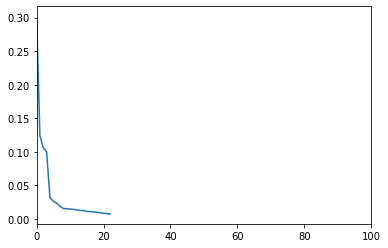

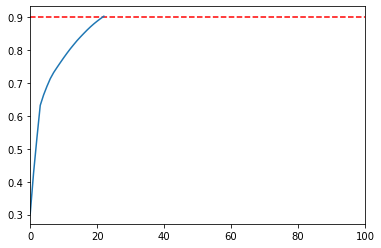

In [ ]:
# Réduction de la dimension via PCA

pca = PCA(n_components = 0.9)
pca.fit(X)
print("Nombre de composantes retenues :", pca.n_components_)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure()
plt.xlim(0,100)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,100)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());



In [ ]:
# Test algo classification 1
# Ce test se base sur les métadonnées, les compteurs et n_grams 2 et 3 des commentaires uniquement.

# RandomForest
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train_pca, y_train)
score_rfc=RFC.score(X_test_pca, y_test)
print(score_rfc)

y_pred=RFC.predict(X_test_pca)
print(classification_report(y_test, y_pred))

0.7614198170460937
              precision    recall  f1-score   support

           0       0.72      0.68      0.70     13717
           1       0.79      0.82      0.80     20062

    accuracy                           0.76     33779
   macro avg       0.75      0.75      0.75     33779
weighted avg       0.76      0.76      0.76     33779



(-0.8, 1.5)

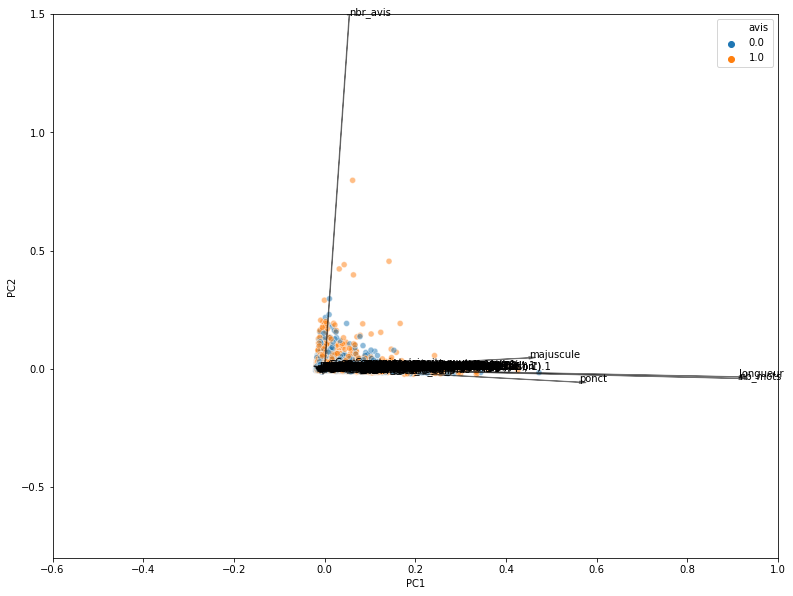

In [ ]:
n = X_train.shape[1]

coeff = pca.components_.transpose()
xs = X_train_pca[:, 0]
ys = X_train_pca[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())

principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred=RFC.predict(X_test_pca)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='avis')], axis=1)


plt.figure(figsize=(13, 10))

sns.scatterplot(x='PC1', y='PC2', hue='avis', data=finalDF, alpha=0.5)

for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.6, 1)
plt.ylim(-0.8, 1.5)